# Determine the eccentricity value for each nodule cell

How far away from the nodule cross-section center is every cell?

In [1]:
import os

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import tifffile as tf

from scipy import ndimage, spatial
from importlib import reload
import utils

In [2]:
sample = 'D2'
struc1 = ndimage.generate_binary_structure(2,1)
struc2 = ndimage.generate_binary_structure(2,2)

wsrc = os.pardir + os.sep + 'cell_dams' + os.sep
csrc = os.pardir + os.sep + 'data' + os.sep
ksrc = os.pardir + os.sep + 'kde' + os.sep + sample + os.sep

wc = np.loadtxt(ksrc + sample + '_icoords.csv', delimiter=',', dtype=int)
wc = wc[:, ~np.all(wc%100, axis=0)]
metacell = pd.read_csv(ksrc + sample + '_cells_metadata.csv', index_col='ndimage_cellID')

We only want to consider nodule cells. Through ImageJ, we record the coordinates of a polygon than encompasses just the nodule. 

A convex hull of this polygon is made. Only the cells whose center lies inside this convex hull are considered part of the nodule.

Make sure the background (ID 1) is not considered part of the nodule.

In [3]:
rcoords = np.loadtxt(wsrc + 'removing_root_from_nodule.csv', dtype=int, delimiter=',', skiprows=1)
convexhull0 = spatial.ConvexHull(rcoords)
hull0 = convexhull0.points[convexhull0.vertices]

coms = metacell.loc[:, ['ndimage_comX', 'ndimage_comY']]
inhull = pd.Series( utils.hull_contained(coms.values, convexhull0), index=coms.index )
inhull[1] = False

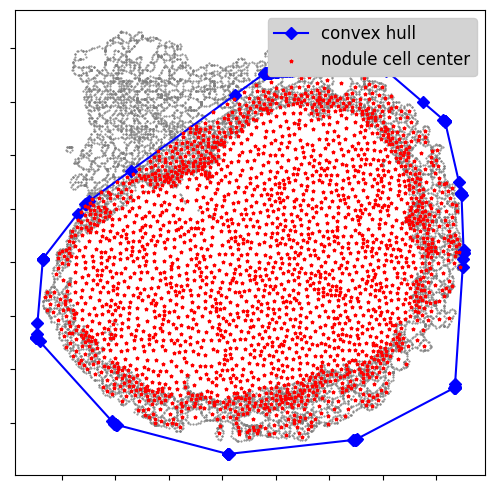

In [4]:
fs = 12
fig, ax = plt.subplots(1,1,figsize=(8,5), sharex=True, sharey=True)
ax = np.atleast_1d(ax).ravel()

ax[0].scatter(wc[1], wc[0], marker='.', s=1, c='gray', zorder=1)
ax[0].plot(*hull0.T, c='b', zorder=2, label='convex hull', marker='D')
ax[0].scatter(*coms.values[inhull].T, marker='*', s=5, c='r', zorder=4, label='nodule cell center')
ax[0].legend(fontsize=fs, loc='upper right', framealpha=1, facecolor='lightgray')
ax[0].tick_params(labelleft=False, labelbottom=False)
ax[0].set_aspect('equal')
fig.tight_layout();

#plt.savefig(wsrc + 'inside_ring_hull.png', dpi=200, format='png', bbox_inches='tight')

# Now onto eccentricity

- Look at the block made by all the nodule cells
- Dilate, fill the holes, and erode this block to remove any noisy irregularities
- Compute the border of this block
- Compute the convex hull of this border

This is essentially readjusting and tightening the convex hull above. Readjust in the sense that we're including nodule cells that the first hull cut in half. Tightening in the sense that background blank space is minimized.

Once we have this improved hull, we can easily compute the distance from it to any other point.

Notice that `inhull` is just a boolean array. Here we are looking for cells inside the nodule. This could be easily modified so that we look at the convex hull of only the infected cells, which should give us a much tighter hull. That way, we can get just the cell wall coordinates of cells outside the infection zone. Reducing the number of wall points will de-clutter future plots.

This is how the `D2_icoords.csv` file was computed.

In [5]:
wall = tf.imread(wsrc + sample + '_dams.tif').astype(bool)
label, cellnum = ndimage.label(wall, ndimage.generate_binary_structure(2,1))
css = ndimage.find_objects(label)

print('Detected',cellnum,'cells')
wcoords = np.asarray(np.nonzero(~wall))

Detected 2937 cells


In [6]:
nodule = np.zeros(label.shape, dtype=bool)

for cidx in metacell.loc[inhull].index.values:
    nodule[css[cidx-1]][ label[css[cidx-1]] == cidx] = True

its = 8
nodule = ndimage.binary_dilation(nodule, struc2, iterations = its, border_value=0)
nodule = ndimage.binary_fill_holes(nodule)
nodule = ndimage.binary_erosion(nodule, struc2, iterations = its//2, border_value=1)

border = utils.borderize(nodule)
border = np.asarray(np.nonzero(border))

In [8]:
convexhull = spatial.ConvexHull(np.flip(border.T, axis=1))
hull = convexhull.points[convexhull.vertices].astype(int)

A0, b0 = convexhull0.equations[:, :-1], convexhull0.equations[:, -1:]
A, b = convexhull.equations[:, :-1], convexhull.equations[:, -1:]

wedt = np.flip(wcoords, axis=0).T @ A.T + b.T
wedt = -np.max(wedt, axis=1)
iwcoords = wcoords[:, wedt < 0.1 ]

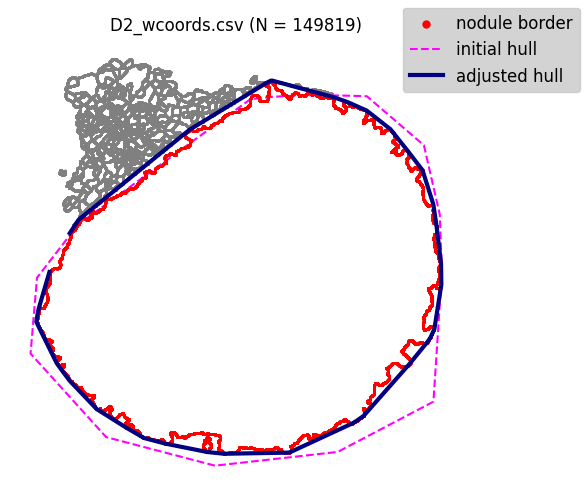

In [54]:
fig, ax = plt.subplots(1,1,figsize=(7,5), sharex=True, sharey=True)
ax = np.atleast_1d(ax).ravel(); i = 0

ax[i].scatter(iwcoords[1], iwcoords[0], marker='.', s=1, c='gray', zorder=1)
ax[i].scatter(border[1], border[0], c='r', marker='.', s=1, zorder=3, label='nodule border')
ax[i].plot(hull0[:,0], hull0[:,1], c='magenta', zorder=2, label='initial hull', ls='dashed')
ax[i].plot(hull[:,0], hull[:,1], c='navy', lw=3, zorder=4, label='adjusted hull')

ax[i].set_title(sample + '_wcoords.csv (N = {})'.format(iwcoords.shape[1]), fontsize=fs); i+=1
for a in ax:
    #a.tick_params(labelleft=False, labelbottom=False)
    a.axis('off')
    a.set_aspect('equal')
    a.set_facecolor('snow')
fig.legend(loc='upper right', fontsize=fs, framealpha=1, facecolor='lightgray', markerscale=10)
fig.tight_layout();

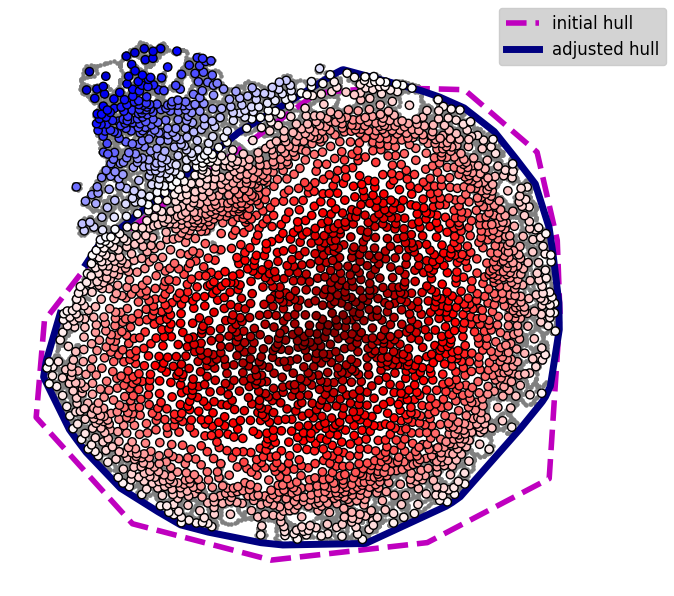

In [59]:
fig, ax = plt.subplots(1,1,figsize=(7.5,6), sharex=True, sharey=True)
ax = np.atleast_1d(ax).ravel(); i = 0

ax[i].scatter(wc[1], wc[0], marker='o', s=5,  c='gray', zorder=1)
ax[i].plot(hull0[:,0], hull0[:,1], c='m', lw=4, zorder=2, label='initial hull', ls='dashed')
ax[i].plot(hull[:,0], hull[:,1], c='navy', lw=5, zorder=4, label='adjusted hull')
ax[i].scatter(coms.iloc[1:,0], coms.iloc[1:,1], marker='o', 
              c=ecc[1:], edgecolor='k', zorder=5, vmin=-ecc.max(), cmap='seismic')

ax[i].set_aspect('equal')
ax[i].axis('off')
ax[i].set_facecolor('dimgray')
fig.legend(loc='upper right', fontsize=fs, framealpha=1, facecolor='lightgray', markerscale=10)
fig.tight_layout();

#plt.savefig(wsrc + 'eccentricity_root_nodule.png', dpi=200, format='png', bbox_inches='tight')

In [60]:
# Uncomment below to save the resulting file

eccentricity = pd.DataFrame(index=metacell.index)
eccentricity['inside_hull'] = inhull
eccentricity['eccentricity'] = ecc
#eccentricity.to_csv(ksrc + sample + '_nodule_root_eccentricity.csv', index=True)

eccentricity.head()

,inside_hull,eccentricity
ndimage_cellID,,
1,False,4855.214899
2,True,286.910089
3,True,172.842962
4,True,127.708285
5,True,231.858572


# A much more inefficient way to compute eccentricity

The code below is how eccentricity was actually computed. (It wasn't until much later that I realized that there was a much better way to do it.) The results are almost identical for infected cells.

- Fill in this hull (this is a time-consuming step that is avoided with the code above)
- Get the Euclidean Distance Transform of the pixels that make up the filled-in hull

In [28]:
ch = np.zeros(nodule.shape, dtype=bool)
for i in range(bhull[:,1].min()-1 , bhull[:,1].max()+1):
    
    # Fill in the convex hull row by row so memory usage is kept low
    
    hline = np.column_stack((np.arange(ch.shape[1]),np.full(ch.shape[1],i)))
    ch[i] = utils.hull_contained(hline, convexhull)
    
edt = ndimage.distance_transform_edt(ch)
nonedt = ndimage.distance_transform_edt(~ch)

In [ ]:
fig, ax = plt.subplots(1,2,figsize=(10,5), sharex=True, sharey=True)
ax = np.atleast_1d(ax).ravel()

ax[0].imshow(edt, origin='lower')
ax[1].imshow(nonedt, origin='lower')

for i in range(len(ax)):
    ax[i].plot(hull[:,0], hull[:,1], c='r', zorder=2)
    ax[i].scatter(border[1], border[0], c='b', marker='.', s=1, zorder=3)
    ax[i].plot(bhull[:,0], bhull[:,1], c='cyan', zorder=4)
    ax[i].axis('off')
    ax[i].set_aspect('equal')

fig.tight_layout();

In [47]:
ecc = np.zeros(len(metacell))

coms = metacell.loc[:, ['ndimage_comX', 'ndimage_comY']].values.astype(int)
ecc[inhull] = edt[coms[inhull,1], coms[inhull,0]]
#ecc[inhull] = ecc[inhull].max() - ecc[inhull]

ecc[~inhull] = -nonedt[coms[~inhull,1], coms[~inhull,0]]
#ecc[~inhull] = -1*(ecc[~inhull].max() - ecc[~inhull])
#ecc[0] = -nonedt.max()
vmax = ecc.max()